# Insper: Profa Maria Kelly Venezuela

# Ciência dos dados: Engenharias

# Projeto 3: PNADC - Uso dos microdados de 2023

# Grupo: Danilo Ramos, Leonardo Veras e Thomas Ganut
___


___
<div id="indice"></div>

## Índice

- [Importando bibliotecas](#bibliotecas)
- [A. Introdução](#intro)
    - [Objetivo escolhido](#objetivo)
    - [Targets](#target)
    - [Features](#features)
    - [Leitura da base de dados](#leitura)
- [B. Minerando Dados e Características do Dataset](#b)
    - [Limpando os outliers](#outliers)
    - [Mudando o tipo para 'category'](#category)
    - [Limpando o DF e tirando os "NaN"](#limpando)
    - [Definindo valores de X e Y e dummies](#xey)
    - [Gráficos de análise das features e target](#graficos)
- [C. Modelos de Predição](#c)
    - [Limpando o X a partir do Valor-P](#valorp)
    - [ProbPlot](#probplot)
    - [Mapa de calor para comparação entre as features dummies](#heatmap)
- [D. Processo e Estatísticas de Validação](#d)
    - [Dividindo a base de dados de treino e a de teste](#testetreino)
    - [Modelo de Regressão Linear](#ols)
    - [Modelo Random Forest](#randomForest)
- [E. Conclusão](#e)
    - [Comparação entre os dois modelos](#comp_modelos)
    - [Comparação dos métodos de Validação](#comp_valid)
    - [Análise dos Resultados de Validação](#result_valid)
    - [Respondendo a pergunta inicial](#respondendo)
    - [Programa para facilitar ao usuário final usar o sistema fora do Jupyter](#programa)
- [F. Referências Bibliográficas](#f)

- [](#)
___

<div id="bibliotecas"></div>

# Importando bibliotecas

In [759]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from funcao import regress, pega_variaveis

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization

from sklearn.model_selection import train_test_split # data split
from sklearn.linear_model import LinearRegression # OLS algorithm

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn import svm
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


sb.set_style('whitegrid') # plot style

##### [Voltar ao índice](#indice)

___
<div id="intro"></div>

## A. Introdução

<div id="objetivo">

### Objetivo escolhido:

O **tema** escolhido pelo grupo é como a classe social e a área de atuação podem determinar o salário de um indíviduo.<br>
Ao começar a analise de dados, vimos que ainda estava muito amplo e resolvemos reduzir mais. Assim, a variável target passou a ser de indivíduos que moram na região Sul ou Sudeste e que tenham, pelo menos, Ensino Médio completo.
<br>
</div>

<div id="target">

O ***target*** escolhido pelo grupo é "Qual era o rendimento bruto/retirada mensal que ... recebia/fazia normalmente nesse trabalho? (valor em dinheiro)" (variável V403312 - quantitativa).
</div>

<div id="features">

O grupo dividiu as ***features*** escolhidas para o projeto em três temas, sendo estes "Classe social", "Área de atuação" e "Classificações gerais".

#### Classe social
- Cor ou raça (V2010)
- ... sabe ler e escrever? (V3001)
- A escola que ... frequenta é de (V3002A)
- Nível de instrução mais elevado alcançado (pessoas de 5 anos ou mais de idade) padronizado para o Ensino fundamental -  SISTEMA DE 9 ANOS (VD3004)

#### Área de atuação
- Nesse trabalho, ... era: (V4012)
- Em que tipo de local funcionava esse negócio/empresa? (V4020)
- Nesse trabalho, ... tinha carteira de trabalho assinada? (V4029)


#### Classificações gerais
- Unidade da Federação (UF)
- Tipo de área (V1023)
- Idade do morador na data de referência (V2009)
</div>

___
<div id="leitura">

# Leitura da base de dados - PNADC 2023:

#### OBS: Leitura feita em um arquivo separado: "exportar_vsc_reduzido.py", que pode ser encontrado na mesma pasta desse Jupyter Notebook.
</div>

In [760]:
df = pd.read_csv('output.csv')

df = df.dropna(subset=['Salario', 'Carteira', 'LocalTrabalho']).reset_index(drop=True)

##### [Voltar ao índice](#indice)

___
<div id="b">


## B. Minerando Dados e Características do Dataset
</div>

<div id='outliers'>

#### Limpando outliers do Salario e fazendo boxplot antes e depois da limpeza
</div>

Ao testar o modelo pela primeira vez, notamos que havia muitos outliers no target. Assim, iteramos o código para limpar os outliers mais extremos.

Outliers removidos: 8405


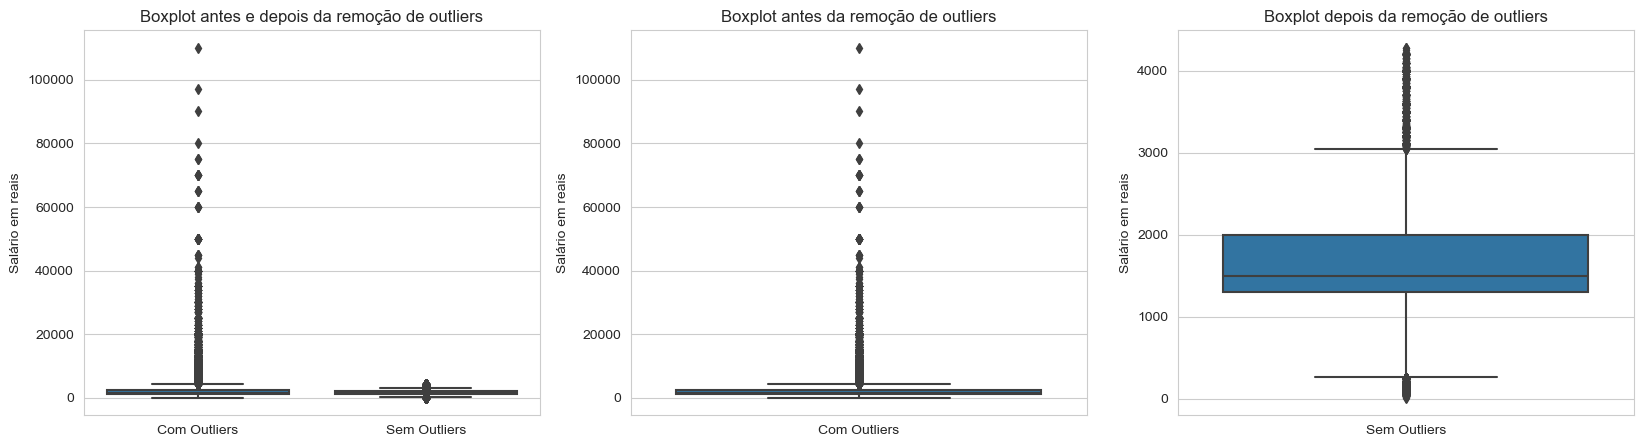

In [761]:
# Limpar os outliers

# Calcular os quartis e o IQR
Q1 = df['Salario'].quantile(0.25)
Q3 = df['Salario'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites inferior e superior para os outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar os dados, removendo os outliers
df_sem_outliers = df[(df['Salario'] >= limite_inferior) & (df['Salario'] <= limite_superior)].reset_index(drop=True)

# Verificar a quantidade de outliers removidos
print(f"Outliers removidos: {len(df) - len(df_sem_outliers)}")

plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.boxplot(data=[df['Salario'], df_sem_outliers['Salario']])
plt.xticks([0, 1], ['Com Outliers', 'Sem Outliers'])
plt.ylabel('Salário em reais')
plt.title('Boxplot antes e depois da remoção de outliers')

plt.subplot(132)
sns.boxplot(df['Salario'])
plt.xticks([0], ['Com Outliers'])
plt.ylabel('Salário em reais')
plt.title('Boxplot antes da remoção de outliers')

plt.subplot(133)
sns.boxplot(df_sem_outliers['Salario'])
plt.xticks([0], ['Sem Outliers'])
plt.ylabel('Salário em reais')
plt.title('Boxplot depois da remoção de outliers')
plt.show()


df = df_sem_outliers

<div id='category'>

#### Mudando o tipo para 'category'
</div>

In [762]:
# Mudando o tipo para 'category'
colunas = ['Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao', 'TipoTrabalho', 'LocalTrabalho']
for coluna in colunas:
    df[coluna] = df[coluna].astype('category')

# Renomeando as categorias
df['Estado'] = df['Estado'].cat.rename_categories({
    11: 'Rondônia', 12: 'Acre', 13: 'Amazonas', 14: 'Roraima', 15: 'Pará', 16: 'Amapá', 17: 'Tocantins', 
    21: 'Maranhão', 22: 'Piauí', 23: 'Ceará', 24: 'Rio Grande do Norte', 25: 'Paraíba', 26: 'Pernambuco', 27: 'Alagoas', 28: 'Sergipe', 29: 'Bahia', 
    31: 'Minas Gerais', 32: 'Espírito Santo', 33: 'Rio de Janeiro', 35: 'São Paulo', 
    41: 'Paraná', 42: 'Santa Catarina', 43: 'Rio Grande do Sul', 
    50: 'Mato Grosso do Sul', 51: 'Mato Grosso', 52: 'Goiás', 53: 'Distrito Federal'
})

df['AreaRes'] = df['AreaRes'].cat.rename_categories({
    1: 'Capital', 2: "Resto da RM", 3: 'Resto da RIDE', 4: 'Resto da UF' # RIDE = Região Integrada de Desenvolvimento Econômico
})

df['CorRaca'] = df['CorRaca'].cat.rename_categories({
    1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indigena', 9: 'Ignorado' 
})

df['Analfabeto'] = df['Analfabeto'].cat.rename_categories({
    1: 'Nao', 2: 'Sim'
})

df['Carteira'] = df['Carteira'].cat.rename_categories({
    1: 'Sim', 2: 'Nao'
})

df['Instrucao'] = df['Instrucao'].cat.rename_categories({
    1: '<1 ano', 2: 'Fund. incompleto', 3: 'Fund. completo', 4: 'EM incompleto', 5: 'EM completo', 6: 'Sup. incompleto', 7: 'Sup. completo', 
})

df['TipoTrabalho'] = df['TipoTrabalho'].cat.rename_categories({
    1: 'Trabalhador doméstico',
    2: 'Militar',
    3: 'Setor privado',
    4: 'Setor público',
    5: 'Empregador',
    6: 'Conta própria',
    7: 'Familiar não remunerado'
})

df['LocalTrabalho'] = df['LocalTrabalho'].cat.rename_categories({
    1: 'Cidade', 2: 'Fazenda', 3: 'Sem estabelecimento'
})

<div id='limpando'>

#### Limpando o DF a partir do tema definido e para que não tenha valores "NaN"
</div>

In [763]:
# Limpando o DF

# Define um df específico
df = df.loc[
    (df['Estado'].isin(['São Paulo', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul'])) &
    (df['Instrucao'].isin(['Sup. completo', 'Sup. incompleto', 'EM completo']))
]

# Verifica se não tem NaN em nenhuma coluna
colunas = ['Idade', 'Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao', 'TipoTrabalho', 'LocalTrabalho']
print("Quantidade de NaN em cada coluna:")
for coluna in colunas:
    print(f'{coluna}:', df[coluna].isna().sum())

# Filtre o DataFrame para manter apenas as categorias com contagem maior que zero
df = df[(df['Estado'].notna()) & (df['AreaRes'].notna()) & (df['Instrucao'].notna())]
df['Estado'] = df['Estado'].cat.remove_unused_categories()
df['AreaRes'] = df['AreaRes'].cat.remove_unused_categories()
df['Instrucao'] = df['Instrucao'].cat.remove_unused_categories()
df['TipoTrabalho'] = df['TipoTrabalho'].cat.remove_unused_categories()

print(f'\nQuantidade de pessoas no df: {len(df)}')

Quantidade de NaN em cada coluna:
Idade: 0
Estado: 0
AreaRes: 0
CorRaca: 0
Analfabeto: 0
Carteira: 0
Instrucao: 0
TipoTrabalho: 0
LocalTrabalho: 0

Quantidade de pessoas no df: 29314


<div id='xey'></div>

#### Definindo valores X e Y e respectivos dummies


In [764]:
# Dummies e define X e Y
dummies = pd.get_dummies(df.drop(columns=['Salario']), dtype=int)
df = pd.concat([df, dummies], axis=1)

Y = df['Salario']
X = dummies

X = sm.add_constant(X)

modelo = sm.OLS(Y, X)
resumo = modelo.fit()

<div id='graficos'></div>

#### Gráficos de análise das features e do target



Histograma para análise da distribuição do salário

C:\Users\Leo\AppData\Local\Temp\ipykernel_5524\1093448984.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Salario'], color = 'r', bins=20)
f:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


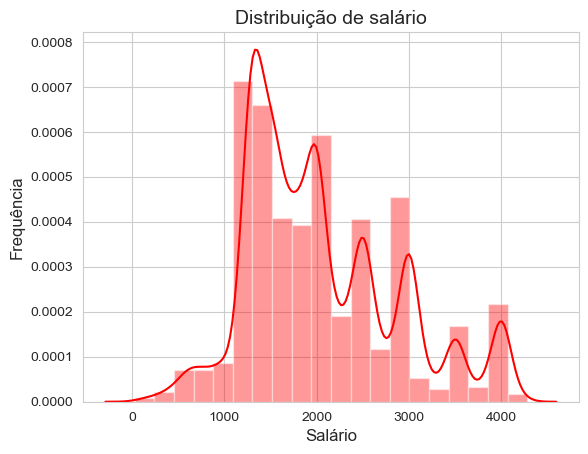

In [765]:
sb.distplot(df['Salario'], color = 'r', bins=20)
plt.title('Distribuição de salário', fontsize = 14)
plt.xlabel('Salário', fontsize = 12)
plt.ylabel('Frequência', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()


Barplot para análise da quantidade de valores de cada variável independente

f:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


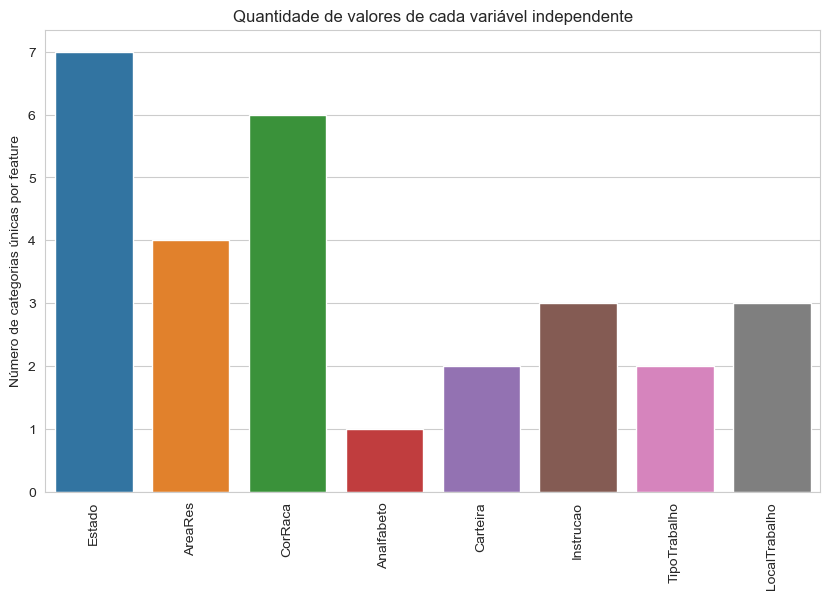

In [766]:
unique_values = []
colunas_idade = ['Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao', 'TipoTrabalho', 'LocalTrabalho']
df_idade = df.drop(columns=['Idade'])

for coluna in colunas_idade:
    unique_values.append(df_idade[coluna].unique().size)
plt.figure(figsize=(10,6))
plt.title('Quantidade de valores de cada variável independente')
plt.xticks(rotation=90)
plt.ylabel('Número de categorias únicas por feature')
sns.barplot(x=colunas_idade,y=unique_values)
plt.show()

##### [Voltar ao índice](#indice)

___
<div id="c">

## C. Modelos de Predição
</div>

<div id='valorp'></div>

#### Limpando o X a partir do Valor-P

##### OBS: Usamos uma função escrita no arquivo "funcao.py", também disponível junto desse arquivo

In [767]:
# Limpar o X a partir do Valor P
from funcao import regress, pega_variaveis

X_final = pega_variaveis(Y, X, 0.5)
results = regress(Y, X_final)

<div id='probplot'></div>

#### ProbPlot pra verificar a colinearidade do X


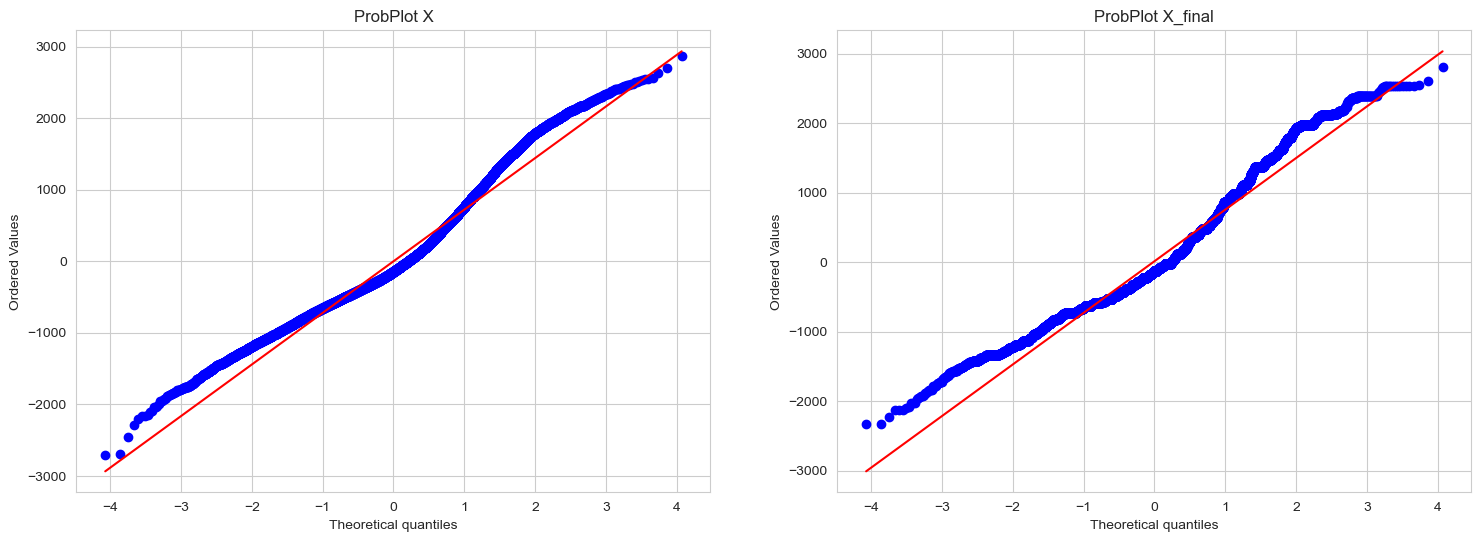

In [768]:
# ProbPlot
plt.figure(figsize=(18,6))
plt.subplot(121)
results = regress(Y, X)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.title('ProbPlot X')

plt.subplot(122)
results = regress(Y, X_final)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.title('ProbPlot X_final')

plt.show()

<div id='heatmap'></div>

#### Mapa de calor para comparação entre as features dummies


f:\Anaconda\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


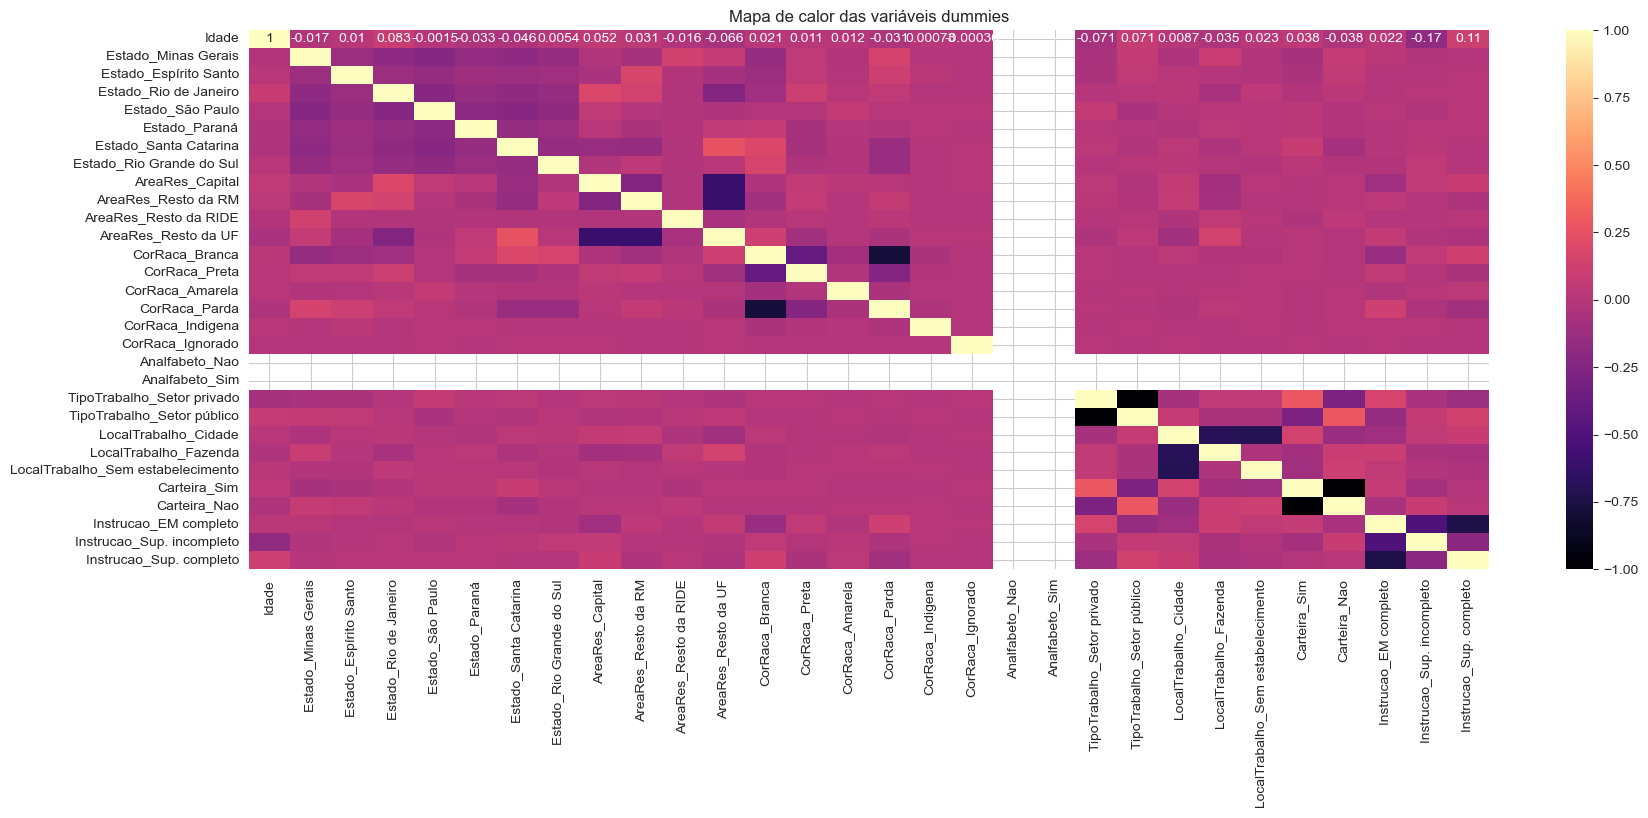

In [769]:
# Heat map
plt.figure(figsize=(20, 7))
sb.heatmap(dummies.corr(), annot = True, cmap = 'magma')
plt.title('Mapa de calor das variáveis dummies')
plt.show()

##### [Voltar ao índice](#indice)

___
<div id="d">

## D. Processo e Estatísticas de Validação
</div>

<div id='testetreino'></div>

#### Dividindo a base de dados de treino e a de teste a partir da função "train_test_split"


In [770]:
# Dividir base de teste e dados
X_var = X_final.values
Y_var = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X_var, Y_var, random_state = 0)

print('X_train samples:', X_train[0:5])
print('X_test samples:', X_test[0:5])
print('Y_train samples:', Y_train[0:5])
print('Y_test samples:', Y_test[0:5])

X_train samples: [[1 0 0 0 0 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 1 0 1 0 0 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 1 0 1 0 1 0 0 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 0 0 0]]
X_test samples: [[1 0 0 0 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 1 0 1 0 1 0 0 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 1 1 0]
 [0 1 0 0 0 1 0 1 0 0 0 1 0]]
Y_train samples: [2500. 2010. 2000. 1302. 4000.]
Y_test samples: [3000. 2000. 2250. 1212. 1900.]


<div id='ols'></div>

#### Usando o modelo de Regressão Linear para testar nossa base de dados e validando os resultados


In [771]:
# OLS - Linear Regression
ols = LinearRegression()
ols.fit(X_train, Y_train)
ols_yhat = ols.predict(X_test)

print('-------------------------------------------------------------------------------')
print(f'Explained Variance Score of OLS (Linear Regression) model is {evs(Y_test, ols_yhat)}')
print('-------------------------------------------------------------------------------')
print(f'R-Squared of OLS model is {r2(Y_test, ols_yhat)}')
print('\n-------------------------------------------------------------------------------\n')
print(f'Mean Absolute Percentage Error (MAPE) of OLS model is {mean_absolute_percentage_error(Y_test, ols_yhat)}') # mean_absolute_percentage_error
print('-------------------------------------------------------------------------------')
print(f'Root Mean Squared Error (RMSE) of OLS model is {np.sqrt(mean_squared_error(Y_test, ols_yhat))}') # Calcula o erro quadrático médio e tira sua raiz quadrada
print('-------------------------------------------------------------------------------')

-------------------------------------------------------------------------------
Explained Variance Score of OLS (Linear Regression) model is 0.1465255031413888
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.14624756735930133

-------------------------------------------------------------------------------

Mean Absolute Percentage Error (MAPE) of OLS model is 0.3785982959873754
-------------------------------------------------------------------------------
Root Mean Squared Error (RMSE) of OLS model is 756.4408105216313
-------------------------------------------------------------------------------


<div id='randomForest'></div>

#### Usando o modelo "Random Forest" para testar nossa base de dados e validando os resultados


In [772]:
# Random Forest
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
RFR_yhat = model_RFR.predict(X_test)

print('-------------------------------------------------------------------------------')
print(f'Explained Variance Score of Random Forest is {evs(Y_test, RFR_yhat)}')
print('-------------------------------------------------------------------------------')
print(f'R-Squared of Random Forest is {r2(Y_test, RFR_yhat)}')
print('\n-------------------------------------------------------------------------------\n')
print(f'Mean Absolute Percentage Error (MAPE) of OLS model is {mean_absolute_percentage_error(Y_test, RFR_yhat)}') # mean_absolute_percentage_error
print('-------------------------------------------------------------------------------')
print(f'Root Mean Squared Error (RMSE) of OLS model is {np.sqrt(mean_squared_error(Y_test, RFR_yhat))}') # Calcula o erro quadrático médio e tira sua raiz quadrada
print('-------------------------------------------------------------------------------')

-------------------------------------------------------------------------------
Explained Variance Score of Random Forest is 0.15406012783076328
-------------------------------------------------------------------------------
R-Squared of Random Forest is 0.1538025538909663

-------------------------------------------------------------------------------

Mean Absolute Percentage Error (MAPE) of OLS model is 0.3734852894338977
-------------------------------------------------------------------------------
Root Mean Squared Error (RMSE) of OLS model is 753.0864426889513
-------------------------------------------------------------------------------


<div id='explicacoes'></div>

#### Explicação de cada modelo e cada tipo de validação


##### Modelos

- **Linear Regression**: A regressão linear é um modelo que assume uma relação linear entre as variáveis independentes (*features*) e a variável dependente (*target*). O modelo ajusta uma linha que minimiza o erro quadrático médio (MSE) dos valores observados em relação aos valores previstos. Para prever novos valores, o modelo utiliza a equação dessa linha, associando os valores das *features* a um valor estimado da *target* com base na função linear ajustada.

- **Random Forest**: O modelo de Random Forest para regressão utiliza múltiplas árvores de decisão criadas a partir de diferentes subconjuntos dos dados, combinando suas previsões para gerar um resultado final. No caso de regressão, cada árvore prevê um valor numérico (como o salário), e a média dessas previsões é usada como saída final do modelo. Essa abordagem aleatoriza tanto os dados usados em cada árvore quanto os *splits* dentro das árvores, aumentando a robustez e reduzindo o risco de *overfitting*. Esse processo captura relações mais complexas e interações entre as variáveis, que podem ser difíceis de modelar com uma função linear simples.



##### Métodos de Validação

- **Explained Variance Score (EVS)**: Mede a proporção da variância da variável dependente explicada pelo modelo. O valor varia de 0 (nenhuma variância explicada) a 1 (toda a variância explicada). O nosso está mais perto de 0 do que de 1, o que indica uma má performance. 

- **R-Squared (R^2)**: Indica a fração da variância total dos dados que o modelo explica em relação à média. Valores próximos de 1 indicam um bom ajuste, enquanto valores próximos de 0 sugerem uma má performance (nosso caso).

- **Mean Absolute Percentage Error (MAPE)**: Mede o erro médio absoluto como uma porcentagem dos valores reais. É adequado para entender a precisão relativa do modelo, especialmente em dados com escalas variáveis.

- **Root Mean Squared Error (RMSE)**: Calcula a raiz quadrada do erro quadrático médio, sendo mais sensível a grandes desvios entre os valores previstos e reais. É usado para medir a precisão absoluta do modelo, destacando outliers.


##### [Voltar ao índice](#indice)

___
<div id="e"></div>

## E. Conclusão 


<div id='comp_modelos'></div>

#### Comparação entre os dois modelos

A Regressão Linear é ótima para prever uma variável dependente usando variáveis independentes quando há uma relação linear clara. Ela ajusta uma linha que minimiza o erro quadrático médio (MSE), e seus coeficientes mostram o impacto de cada variável. No entanto, é sensível a outliers e multicolinearidade. Por outro lado, o Random Forest é mais robusto e captura relações não lineares e interações complexas com várias árvores de decisão. É menos afetado por outliers e lida bem com variáveis correlacionadas, mas é mais caro computacionalmente e menos intuitivo.

Se os dados são lineares e o objetivo é a simplicidade, a Regressão Linear pode ser uma boa escolha. Mas, para relações complexas e não lineares, como no caso deste projeto, o Random Forest tende a ser mais eficaz.

Isso é comprovado nos valores resultantes dos testes dos modelos, onde o Random Forest apresenta uma taxa de acerto 7% maior em relação ao modelo da Regressão Linear.

<div id='comp_valid'></div>

#### Comparação dos métodos de Validação

O EVS e o R^2 avaliam a capacidade geral do modelo de explicar a variabilidade dos dados, com R^2 sendo mais interpretável em termos percentuais. Já o MAPE e o RMSE medem a precisão dos acertos, com o MAPE avaliando o erro médio relativo e o RMSE destacando desvios absolutos, especialmente outliers. Juntos, esses métodos fornecem uma visão abrangente do desempenho do modelo, combinando explicabilidade com precisão preditiva.

<div id='result_valid'></div>

#### Análise dos Resultados de Validação

Ambos os valores do EVS e do R^2 são baixos, indicando que o modelo explica apenas cerca de 15% da variância dos dados. Isso sugere que os modelos não estão capturando bem a relação entre as variáveis features e a target. O valor do MAPE para ambos os modelos é cerca de 37%, indicando que, em média, os modelos tem um erro de aproximadamente 37% em relação aos valores reais. O RMSE é cerca de 754, que mede o erro médio absoluto em unidades da target (salários). Estes valores são relativamente altos, mostrando uma precisão não tão alta dos modelos...


<div id='respondendo'></div>

#### Respondendo a pergunta inicial

Baseado na pergunta de "Qual o salário de um brasileiro que mora nas regiões Sul ou Sudeste e tem, pelo menos, ensino médio completo", apesar da performance de predição não tão alta, é possível perceber que as features escolhidas para o modelo mostram relevância considerável quanto ao salário dessa pessoa. Em específico a condição de ter carteira de trabalho ou não foi fortemente correlacionado com mudanção na faixa salarial dessa pessoa. Além disso, foi interessante ver que a feature de cor de pele/raça é uma das que tem a menor influência, o que pode mostrar uma diminuição no racismo estrutural de nossa sociedade. Porém, é importante levar em conta que, como a performance do modelo não foi ideal, essa análise pode ter sido feita erroneamente: por exemplo, os outliers do salário foram retirados no início do modelo, reduzindo a amplitude para apenas os menores salários, não passando de 5 mil reais; ou mesmo por estarmos filtrando por região, podendo diminuir as informações relevantes para dadas cores de pele/raças. Assim, essa relação com a cor de pele/raça pode ser menor do que na realidade.


<div id='programa'></div>

### Programa para facilitar ao usuário final usar o sistema fora do Jupyter

Uma ideia seria a aplicação de um modelo de previsão salarial durante o processo de contratação. Isso permite que empresas ajustem suas ofertas salariais de forma mais precisa e alinhada com o mercado, considerando variáveis como experiência, qualificação, localização e demanda. Esse modelo pode automatizar a análise de grandes volumes de candidatos, garantindo negociações salariais transparentes e justas. Ao integrar fatores regionais e setoriais, a ferramenta assegura que os salários oferecidos sejam competitivos. Essa ferramenta pode ser integrada a plataformas de recrutamento online, onde candidatos preenchem suas informações (como experiência, educação e localização) e o sistema automaticamente calcula uma faixa salarial sugerida.

##### [Voltar ao índice](#indice)

___
<div id="f"></div>

## F. Referências Bibliográficas


- House Price Prediction using Machine Learning in Python - GeekForGeeks:
https://www.geeksforgeeks.org/house-price-prediction-using-machine-learning-in-python/
- House Price Prediction With Machine Learning in Python - Medium:
https://medium.com/codex/house-price-prediction-with-machine-learning-in-python-cf9df744f7ff

- Documentação do train_test_split da biblioteca scikit-learn:
https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html
- Documentação do get_dummies da biblioteca pandas:
https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html